In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
# tensorboard
%load_ext tensorboard --logdir results/logs

In [1]:
# import vgae pytorch geometric
from torch_geometric.nn import VGAE
# GCN, GAT
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, InnerProductDecoder

# torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.loader import DataLoader
import pytorch_lightning as pl
import torch.multiprocessing as mp

# dataset mnist superpixels
from torch_geometric.datasets import MNISTSuperpixels

# dataset shapenetLocal 
from experiment.dataset import ShapeNet

# Model

## Encoder

In [2]:
class GenericEncoder(nn.Module):
    def __init__(self, ConvLayer, in_channels, hidden_channels, out_channels):
        super(GenericEncoder, self).__init__()
        self.conv_shared = ConvLayer(in_channels, hidden_channels)
        self.conv_mu = ConvLayer(hidden_channels, out_channels)
        self.conv_logvar = ConvLayer(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv_shared(x, edge_index))
        mu = self.conv_mu(x, edge_index)
        logvar = self.conv_logvar(x, edge_index)
        return mu, logvar

## Decoder

In [6]:
# from torch_geometric.transforms import InnerProductDecoder

## Autoencoder Node Generation only

In [3]:
class VGAELightning(pl.LightningModule):
    def __init__(self, encoder, decoder, train_dataset, lr, batch_size):
        super(VGAELightning, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.train_dataset = train_dataset
        self.batch_size = batch_size
        self.lr = lr

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def encode(self, *args, **kwargs):
        self.__mu__, self.__logstd__ = self.encoder(*args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=10)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)
    

    def kl_loss(self, z, mu, logvar):
        return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_index)

    def training_step(self, batch, batch_idx):
        x, edge_index = batch.x, batch.edge_index
        z = self.encode(x, edge_index)
        loss = self.kl_loss(z, self.__mu__, self.__logstd__)
        self.log('train_loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def test_step(self, batch, batch_idx):
        x, edge_index = batch.x, batch.edge_index
        z = self.encode(x, edge_index)
        loss = self.kl_loss(z, self.__mu__, self.__logstd__)
        self.log('test_loss', loss)
        return loss
    
    def test_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    


# Autoencoder Node AND Edge Generation

# MNIST-Spatial

In [4]:
# load dataset MnistSuperpixels
train_dataset = MNISTSuperpixels(root='data/MNIST', train=True)
test_dataset = MNISTSuperpixels(root='data/MNIST', train=False)

# initialize loggger
# logger = pl.loggers.TensorBoardLogger('results/logs', name='vgae_mnist')

# # load model 
# encoder = GenericEncoder(GCNConv, 1, 32, 16)
# decoder = InnerProductDecoder()
# model = VGAELightning(encoder, decoder, train_dataset, lr=0.01, batch_size=64)

# # train model
# trainer = pl.Trainer(max_epochs=10, devices=1, logger=logger)
# trainer.fit(model)

# # test model
# trainer.test(model)

# # save model
# torch.save(model.state_dict(), 'vgae_mnist.pt')

In [5]:
# load dataset MnistSuperpixels
train_dataset = MNISTSuperpixels(root='data/MNIST', train=True)
test_dataset = MNISTSuperpixels(root='data/MNIST', train=False)

# initialize loggger
logger = pl.loggers.TensorBoardLogger('results/logs', name='vgae_mnist')

# load model 
encoder = GenericEncoder(GATConv, 1, 32, 16)
decoder = InnerProductDecoder()
model = VGAELightning(encoder, decoder, train_dataset, lr=0.01, batch_size=64)

# train model
trainer = pl.Trainer(max_epochs=10, devices=1, logger=logger)
trainer.fit(model)

# test model
trainer.test(model)

# save model
torch.save(model.state_dict(), 'vgae_mnist_gat.pt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name    | Type                | Params
------------------------------------------------
0 | encoder | GenericEncoder      | 1.2 K 
1 | decoder | InnerProductDecoder | 0     
------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/home/robin/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/robin/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/robin/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/robin/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performa

Testing: 0it [00:00, ?it/s]

/home/robin/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4800. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          1.480422611166432e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/robin/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2400. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


# Shapenet-Sem

## Viz

## MNIST-Superpixel viz

In [7]:
data = train_dataset[1]
data

Data(x=[75, 1], edge_index=[2, 1260], y=[1], pos=[75, 2])

In [10]:
from torch_geometric.data import Data, Dataset
import torch

class FilteredMNISTSuperpixels(Dataset):
    def __init__(self, root, train=True, transform=None, pre_transform=None):
        self.train = train
        super(FilteredMNISTSuperpixels, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        if self.train:
            return ['train_data.pt']
        else:
            return ['test_data.pt']

    @property
    def processed_file_names(self):
        if self.train:
            return ['train_dataset_filtered.pt']
        else:
            return ['test_dataset_filtered.pt']

    def download(self):
        pass

    def process(self):
        for raw_path in self.raw_paths:
            dataset = torch.load(raw_path)

            data_list = []
            for data in dataset:
                edges_to_remove = []
                nodes_to_remove = []

                for edge in data.edge_index.t():
                    node1, node2 = edge[0], edge[1]
                    distance = min(data.x[node1], data.x[node2])
                    if distance < 0.6:
                        edges_to_remove.append(edge)
                        nodes_to_remove.extend([node1, node2])

                # Convert to set to remove any duplicate nodes
                nodes_to_remove = set(nodes_to_remove)

                # Remove edges
                edge_index = torch.tensor([edge for edge in data.edge_index.t() if edge not in edges_to_remove]).t().contiguous()

                # Remove nodes
                x = torch.tensor([data.x[i] for i in range(data.x.shape[0]) if i not in nodes_to_remove])

                data_list.append(Data(x=x, edge_index=edge_index))

            torch.save(self.collate(data_list), self.processed_paths[0])

    def len(self):
        return len(self.processed_dataset)

    def get(self, idx):
        return self.processed_dataset[idx]

filtered_train_dataset = FilteredMNISTSuperpixels(root='data/MNISTFiltered', train=True)
filtered_test_dataset = FilteredMNISTSuperpixels(root='data/MNISTFiltered', train=False)


Processing...


NameError: name 'train_dataset' is not defined

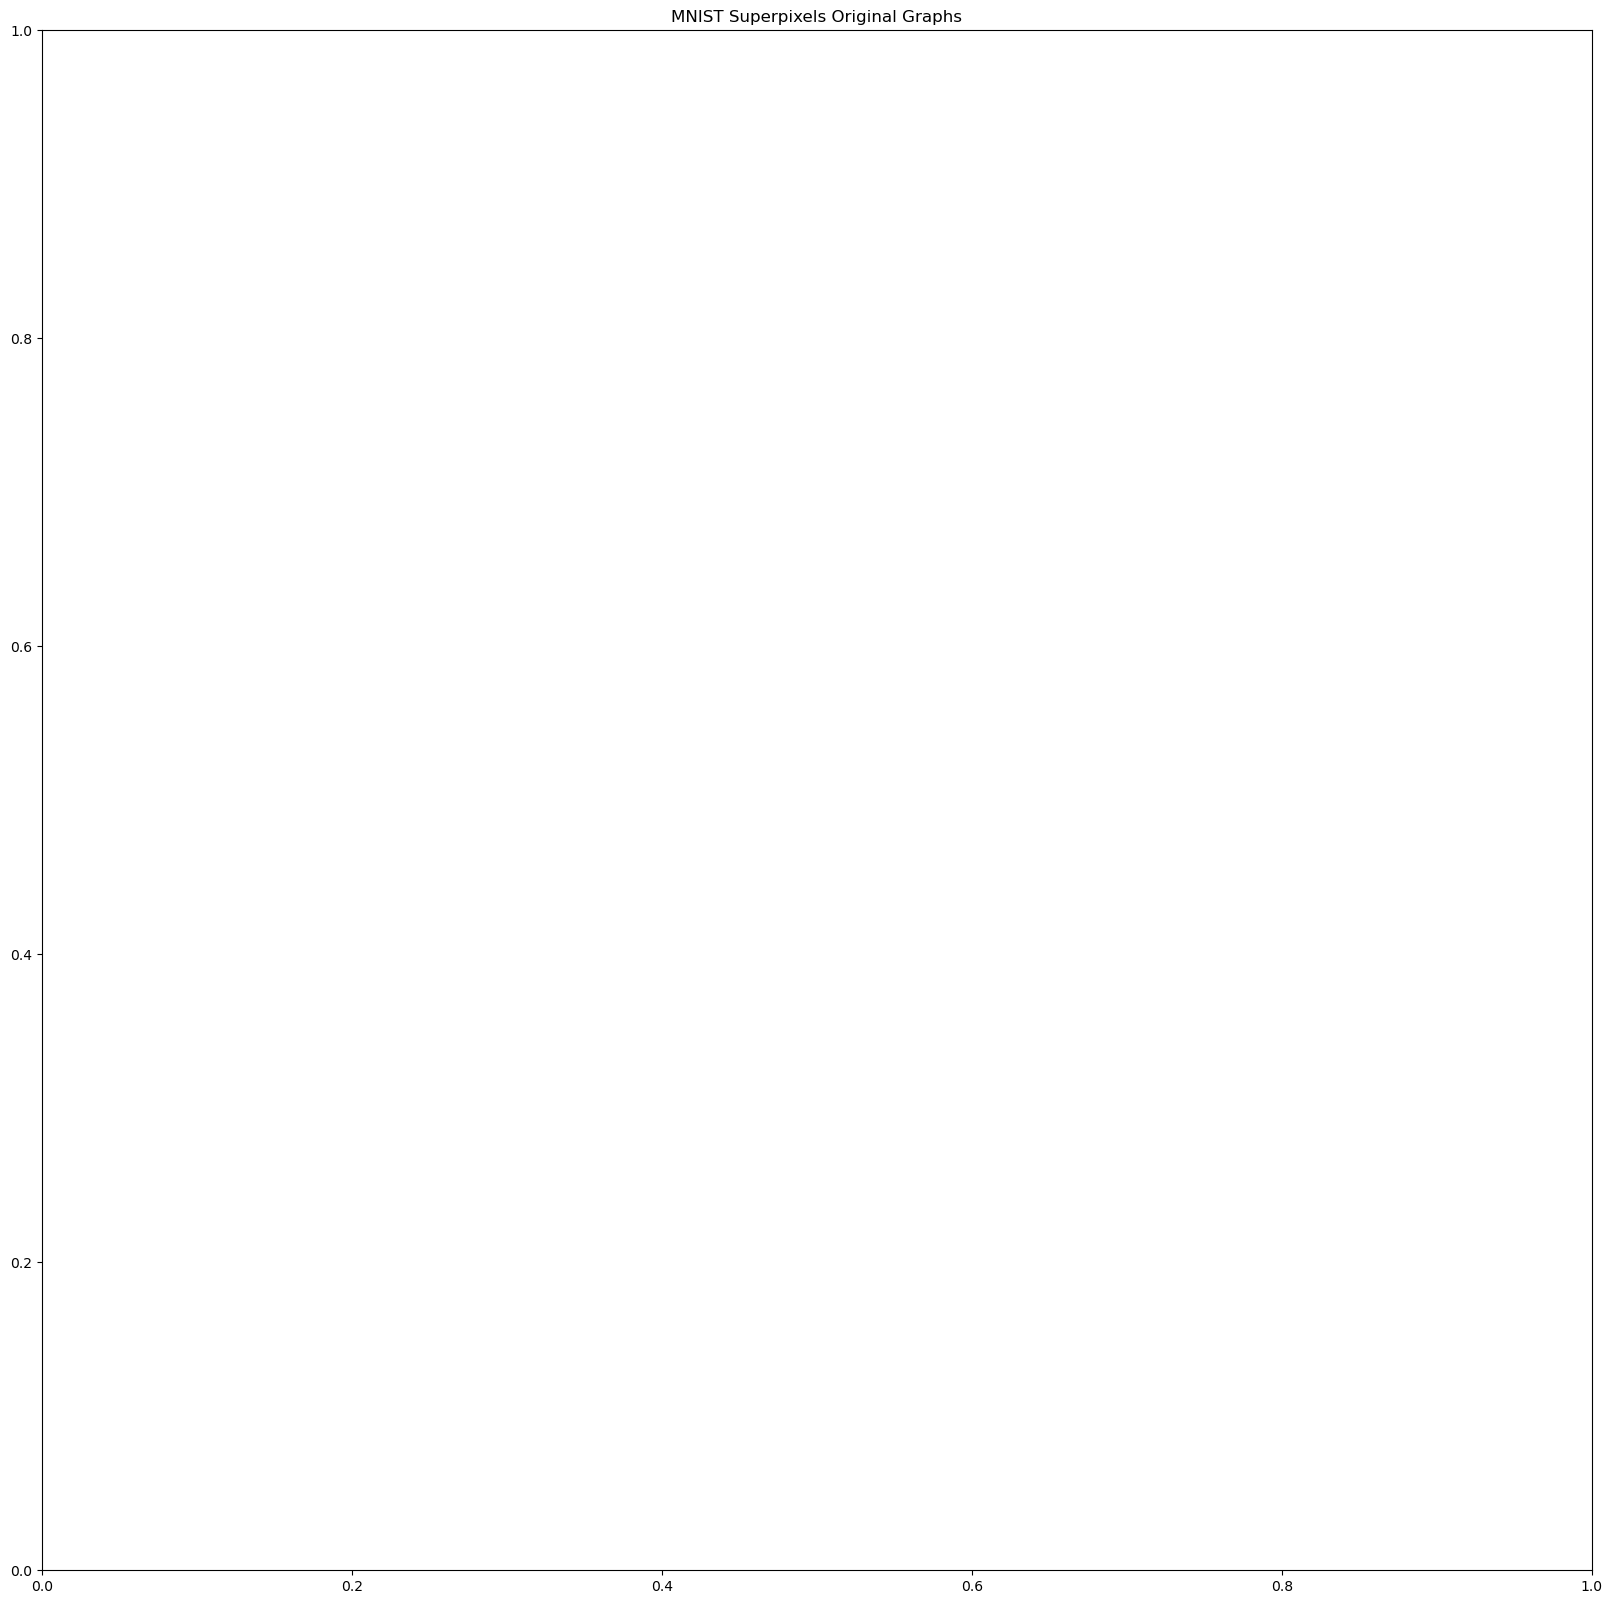

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils.convert import to_networkx

# Create a large figure
fig = plt.figure(figsize=(20, 20))
plt.title('MNIST Superpixels Original Graphs')

# Iterate over the first 64 graphs in the dataset
for i in range(64):
    data = train_dataset[i]

    # Create a graph with all edges
    G = to_networkx(data, to_undirected=True)

    # Calculate Euclidean distances for each edge and remove edges with distance < 0.6
    edges_to_remove = []
    node_to_remove = []
    for edge in G.edges():
        node1, node2 = edge
        distance = min(data.x[node1],data.x[node2])
        if distance < 0.6:
            edges_to_remove.append(edge)

    G.remove_edges_from(edges_to_remove)
    G.remove_nodes_from(node_to_remove)

    node_color = data.x[:,0].numpy()

    # Create a subplot in the grid
    ax = fig.add_subplot(8, 8, i+1)

    pos = data.pos.numpy() # Get node positions

    # Set the color map to go from dark to light
    cmap = plt.get_cmap('Greys')

    # Draw nodes, using the feature values for color
    nx.draw_networkx_nodes(G, pos, node_size=40,  cmap=cmap, node_color=node_color, ax=ax)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax)

    # Remove axis
    ax.axis('off')

    # add title with label 
    ax.set_title(f'Label: {data.y.item()}', size=8)

# Show the figure with all subplots

plt.show()


In [84]:
model.eval()

VGAELightning(
  (encoder): GenericEncoder(
    (conv_shared): GCNConv(1, 32)
    (conv_mu): GCNConv(32, 16)
    (conv_logvar): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)

In [85]:
with torch.no_grad():
    z = model.encode(data.x, data.edge_index)
    recon = model.decoder(z, data.edge_index).detach().numpy()
    print(recon.shape)

(1260,)


In [86]:
data = train_dataset[1]
    
# Disable gradient calculations
with torch.no_grad():
    # Encode
    z = model.encode(data.x, data.edge_index)
    # Decode
    decoded = model.decoder(z, data.edge_index)

ValueError: 'c' argument has 1399 elements, which is inconsistent with 'x' and 'y' with size 75.

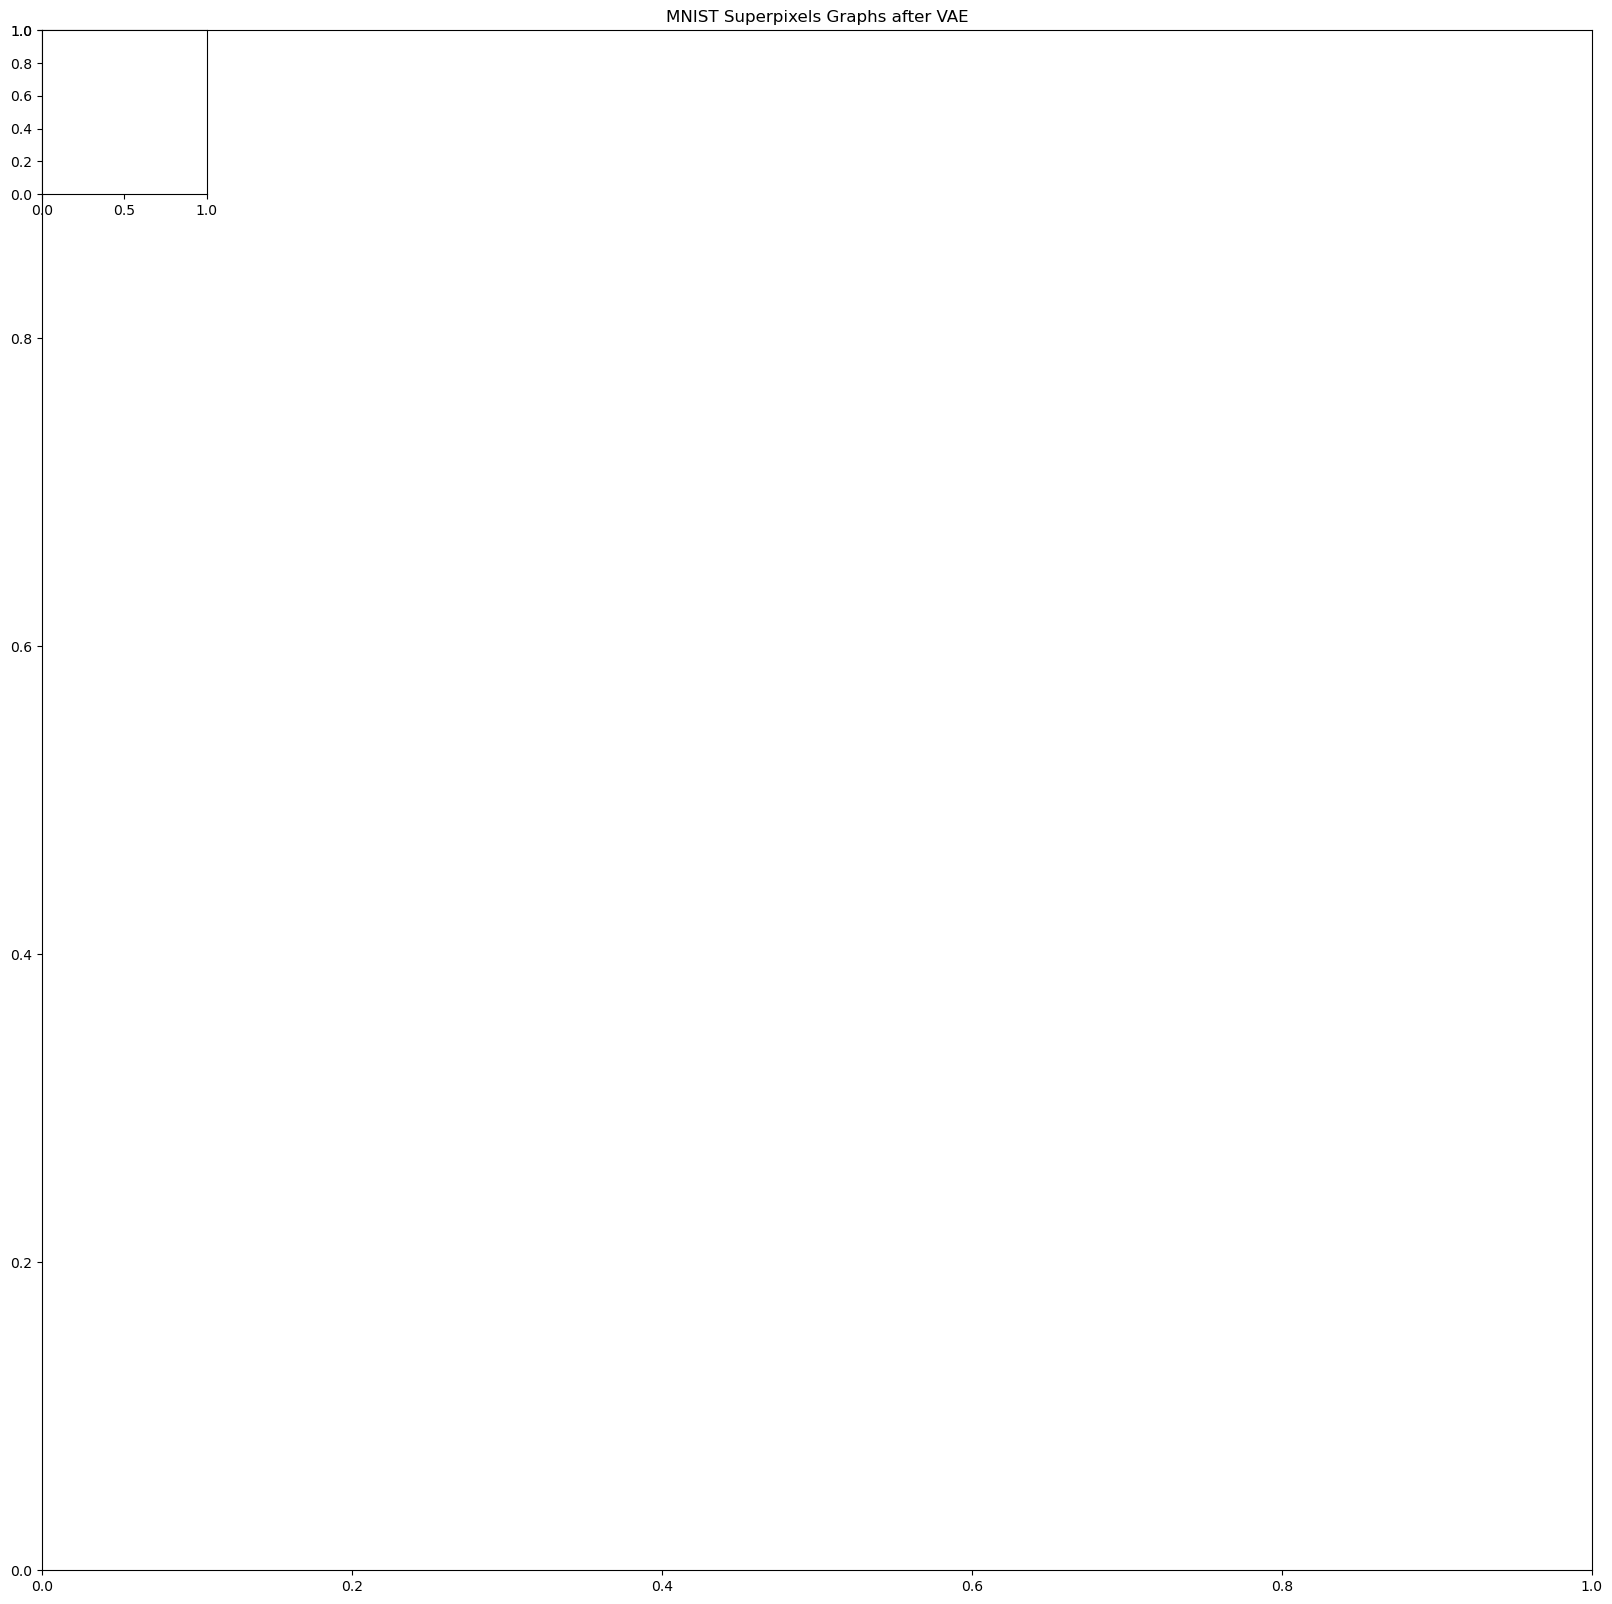

In [74]:
# Create a large figure
fig = plt.figure(figsize=(20, 20))
plt.title('MNIST Superpixels Graphs after VAE')

# Ensure the model is in evaluation mode
model.eval()

# Iterate over the first 64 graphs in the dataset
for i in range(64):
    data = train_dataset[i]
    
    # Disable gradient calculations
    with torch.no_grad():
        # Encode
        z = model.encode(data.x, data.edge_index)
        # Decode
        decoded = model.decoder(z, data.edge_index)

    # Create a graph with all edges
    G = to_networkx(data, to_undirected=True)

    # Calculate Euclidean distances for each edge and remove edges with distance < 0.6
    edges_to_remove = []
    node_to_remove = []
    for edge in G.edges():
        node1, node2 = edge
        distance = min(decoded[node1],decoded[node2])
        if distance < 0.6:
            edges_to_remove.append(edge)
            

    G.remove_edges_from(edges_to_remove)

    node_color = decoded[:].numpy()

    # Create a subplot in the grid
    ax = fig.add_subplot(8, 8, i+1)

    pos = data.pos.numpy() # Get node positions

    # Set the color map to go from dark to light
    cmap = plt.get_cmap('Greys')

    # Draw nodes, using the feature values for color
    nx.draw_networkx_nodes(G, pos, node_size=40, cmap=cmap, node_color=node_color, ax=ax)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax)

    # Remove axis
    ax.axis('off')

    # add title with label 
    ax.set_title(f'Label: {data.y.item()}', size=8)

# Show the figure with all subplots
plt.show()
